In [31]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
from scipy.stats import t, norm
from scipy.optimize import linprog
import sys
import scipy.io
from bisect import bisect
import copy
from optparse import OptionParser

In [32]:
def get_Xcorr(n, dist, sigma):
    '''
    Compute the pdf of the X_Corr variable such that X_norm + X_corr ~ X_logistic
    This version minimizes the CDF error
    input: n    : resolution of discrete X_norm and X_logistic (actual length is 2n + 1)
           dist : read x range encoded over these 2n+1 values (-dist, dist)
           sigma: std deviation of the normal distribution
    '''
    nn = 1

    X = np.linspace(-1*n, n, 2*n+1)/n * dist
    X = X.reshape((1, len(X)))
    lcdfm = 1/(1+np.exp(-1*X))

    lcdf = np.concatenate((np.zeros((1,nn*n)), lcdfm, np.ones((1,nn*n-1)) ), axis=1 )
    ncdfm = np.asarray([norm.cdf(xx,0,sigma) for xx in X])
    ncdf = np.concatenate((np.zeros((1,(nn+1)*n)), ncdfm, np.ones((1,(nn+1)*n-1))), axis=1)
    ndr = 2 * nn + 2
    convmat = np.zeros((ndr*n, 2*n))
    for i in range(0, 2*n):
        convmat[:,i] = (ncdf[0,i:(i+ndr*n)]).T
    tail = lcdf.T + 2.0 * 0.001  # epsilon multiplier for relative error minimization
    tail = np.ones((ndr*n,1))
    A = np.concatenate((convmat, -1.0*convmat))
    temp = np.concatenate((-1.0*tail, -1.0*tail), axis=0)
    A = np.concatenate((A, temp), axis=1)
    b = np.concatenate((lcdf.T, -1.0*lcdf.T))
    Aeq = np.ones((1, 2*n))
    temp2 = np.zeros((1,1))
    temp3 = np.ones((1,1))
    Aeq = np.concatenate((Aeq, temp2), axis=1)
    beq = 1
    f = np.zeros((2*n,1))
    f = np.concatenate((f, temp3))
    f = f.reshape(len(f))
    # scipy.io.savemat('lin.mat',{'f':f, 'A':A, 'b':b,'Aeq':Aeq, 'beq': beq})
    # scipy.io.savemat('convmat.mat',{'convmat':convmat, 'tail':tail})
    print 'start to linprog'
    res = scipy.optimize.linprog(f, A, b, Aeq, beq, bounds=(0, None))
    
    print 'finished linprog'
    epdf = res.x  # estimated X_corr pdf
    ecdf = np.cumsum(epdf)
    u = np.random.random()
    
    Xcorr = X[bisect(ecdf,u)]
    return Xcorr

In [33]:
# Our MH Test
class our_mh:
    def __init__(self, x, ecdfmat, sd_vect):
        self.X = x  # data
        self.N = x.shape[0]
        self.ecdfmat = ecdfmat
        self.sd_vect = sd_vect
    
    def randomWalkProposer(self, theta, eps_sq):
        # random walk proposer to get the next parameter set
        # input: theta: 1-D Array like, of length 2
        #        eps_sq: 2-D Array like, the covariance matrix
        noise = np.random.multivariate_normal(np.array([0,0]), eps_sq).reshape((2,1))
        return theta + noise
    
    def get_lambda(self, theta_c, theta_p, X_mini, N, T, var_X):
        # calculate $\lambda*(\theta, \theta') = 
        # N/b/T * \sum_{i=1}^b\log{p(x_i|\theta')/p(x_i|\theta)}
        
        scale_and_temp = N / float(len(X_mini) * T)
        
        numerator = np.exp(-0.5/var_X * (X_mini - theta_p[0])**2 ) \
                      + np.exp(-0.5/var_X * (X_mini- (theta_p[0] + theta_p[1])) **2 )
        denominator = np.exp(-0.5/var_X * (X_mini - theta_c[0])**2 )\
                      + np.exp(-0.5/var_X * (X_mini - (theta_c[0] + theta_c[1])) ** 2)
        log_terms = scale_and_temp * np.log(numerator/denominator)
        res = np.sum(log_terms)
        return res
    
    def log_f_prior(self, theta, theta_var):
        '''
        function to calculate the prior term : log(p(\theta))
        '''
        Sigma = np.array([[theta_var[0],0],[0,theta_var[1]]])
        res_first_part = -1.0 * np.log( 2 * np.pi * np.sqrt(np.linalg.det(Sigma)) ) 
        res_second_part = -0.5 * (theta.T).dot(np.linalg.inv(Sigma)).dot(theta)
        
        res = (res_first_part + res_second_part)[0,0]
        assert not np.isnan(res)
        return res
    
    def get_phi(self, theta_c, theta_p, u, theta_var):
        # phi(u, \theta, \theta') = log(up(\theta)/p(\theta'))
        prior_old = self.log_f_prior(theta_c, theta_var)
        prior_new = self.log_f_prior(theta_p, theta_var)
        log_u = np.log(u)
        
        assert not np.isnan(prior_old)
        assert not np.isnan(prior_new)
        assert not np.isnan(log_u)
        
        res = log_u + prior_old - prior_new
        return res
    
    def get_Astar_phi(self, theta_c, theta_p, X_mini, N, T, var_X, theta_var):
        # X_mini: minibatch data
        A_star = [self.get_lambda(theta_c, theta_p, np.asarray([x]), N, T, var_X) for x in X_mini]
        A_star = np.asarray(A_star)
        phi = self.get_phi(theta_c, theta_p, 1.0, theta_var)
            
        return (A_star, phi)

    def get_delta(self, A_star, phi):
        A_star = A_star/(len(A_star) * 1.0)
        delta_list = A_star - phi
        delta = np.sum(delta_list)
        return (delta_list, delta)
    
    def estimateVar_from_one_batch(self, delta_list):
        
        varRes = np.var(delta_list)
        
        return varRes
    
    def estimate_eps(self, A_star):
        # get epsilon
        # A_star = N/T * sum(log_term)
        # mb_size = len(A_star)
        A_star_mean = np.sum(A_star)/(len(A_star) * 1.0)
        
        temp_first = A_star - A_star_mean
        temp_third = np.power(temp_first, 3.0)
        f_moment = np.mean(temp_first)
        t_moment = np.mean(temp_third)
        epsilon = (6.4 * t_moment + 2.0 * f_moment) / np.sqrt(len(A_star) * 1.0)
        return epsilon
    
    def add_one_minibatch(self, theta_c, theta_p, X_mini, N, T, var_X, theta_var, old_Astar):
        # add one minibatch and update Delta* \sigma^2(\Delta*) and epsilon estimation
        
        (new_Astar, newphi) = self.get_Astar_phi(theta_c, theta_p, X_mini, N, T, var_X, theta_var)
        A_star = np.concatenate((new_Astar, old_Astar))
        
        (delta_list, delta)= self.get_delta(A_star, newphi)
        varDelta = self.estimateVar_from_one_batch(delta_list)
        epsilon = self.estimate_eps(A_star)
        
        return (delta, varDelta, epsilon, A_star)
    
    def get_rand_xcorr(self, ecdf, sdvect, estimated_sd):
        index = bisect(sdvect, estimated_sd) + 1
        x = ecdf[0,:]
        f = ecdf[index, :]
        u = np.random.random()
        return x[bisect(f, u)]
    
    
    def approximate_mh_test(self, num_passes, rw_eps, temperature, mb_size, theta_start, theta_var, var_X, deta):
        
        our_MH_accept_1 = []
        our_MH_reject_1 = []
        theta_list = theta_start
        data_consume = []
        theta_c = theta_start
        X = self.X
        N = self.N
        T = temperature
        for kk in range(1, num_passes):
            #if (kk % (num_passes/4) == 0):
            #    print kk
            pos = 0
            index = np.random.permutation(N)
            X = X[index]
            
            theta_p = self.randomWalkProposer(theta_c, rw_eps)
            # X_mini = X[np.random.choice(self.N, mb_size, replace=False)]
            X_mini = X[:mb_size]
            pos = pos + mb_size
            
            num_minibatch = 1
            # get delta and epsilon
            (A_star, phi) = self.get_Astar_phi(theta_c, theta_p, X_mini, self.N, T, var_X, theta_var)
            (delta_list, delta) = self.get_delta(A_star, phi)
            varDelta = self.estimateVar_from_one_batch(delta_list)
            eps = self.estimate_eps(A_star)
            
            while varDelta >=1 or eps > deta :
                if pos > N-mb_size-1:
                    break
                X_mini = X[pos:pos+mb_size]
                pos = pos + mb_size
                (delta, varDelta, eps, A_star) = self.add_one_minibatch(theta_c, theta_p, X_mini, N, T, var_X, theta_var, A_star) 
                num_minibatch = num_minibatch + 1
            
            if varDelta >=1 or eps > deta :
                our_MH_reject_1.append(kk)
            else:
                X_corr = self.get_rand_xcorr(self.ecdfmat, self.sd_vect, np.sqrt(1.0 - varDelta))
                X_norm = np.random.normal(0, np.sqrt(1.0 - varDelta))
                # X_corr = get_Xcorr(100,20,np.sqrt(1.0 - varDelta))
                if X_corr + X_norm + delta > 0 :
                    theta_c = theta_p
                    our_MH_accept_1.append(kk)
                else:
                    our_MH_reject_1.append(kk)
            theta_list = np.concatenate((theta_list, theta_c), axis=1)
            data_consume.append(num_minibatch)
        
        return (theta_list, data_consume)

In [34]:
# Generate data
N = 100 # number of points
sigma1_sq = 10
sigma2_sq = 1
sigmax_sq = 2
theta1 = 0
theta2 = 1
X = np.zeros(N)
i = 0
while i < N :
    u = np.random.random()
    if (u<0.5):
        X[i] = np.random.normal(theta1, np.sqrt(sigmax_sq))
        i = i + 1
    else:
        X[i] = np.random.normal(theta1+theta2, np.sqrt(sigmax_sq))
        i = i + 1
        
# Load XcorrCurves.mat
mat = scipy.io.loadmat('../generateXcorr/XcorrCurves.mat')
ecdfmat = mat['res']
sd_vect = mat['sdval']

In [35]:
# *********** Run Our MH Test **********
num_passes = 10000
rw_eps = 0.03 * np.eye(2)
temperature = 110
mb_size = 100
theta = np.array([[0.5],[0]])
num_samples_delta = 5
mavg = 0.05
var_X = 2
theta_var = np.array([10,1])
mhtest = our_mh(X, ecdfmat, sd_vect)

Temperature and minibatch size are:
1 50


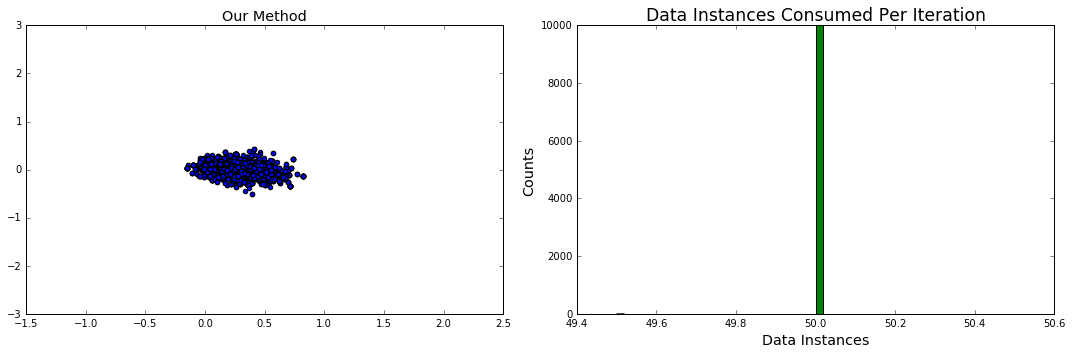

Temperature and minibatch size are:
1 100


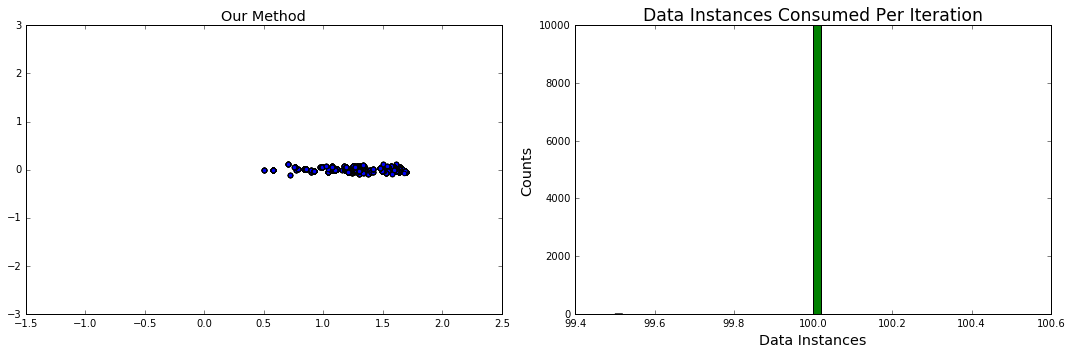

Temperature and minibatch size are:
1 200


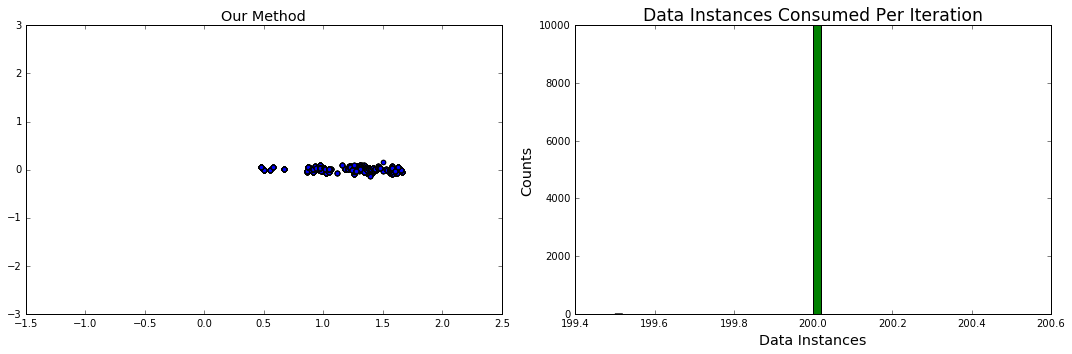

Temperature and minibatch size are:
2 50


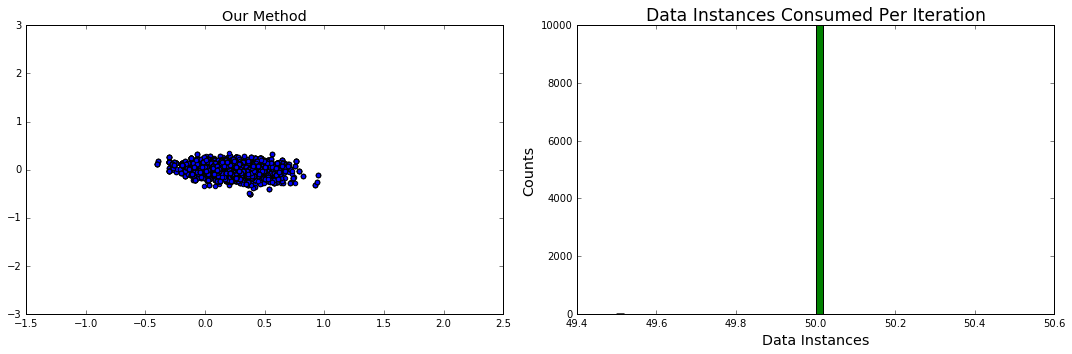

Temperature and minibatch size are:
2 100


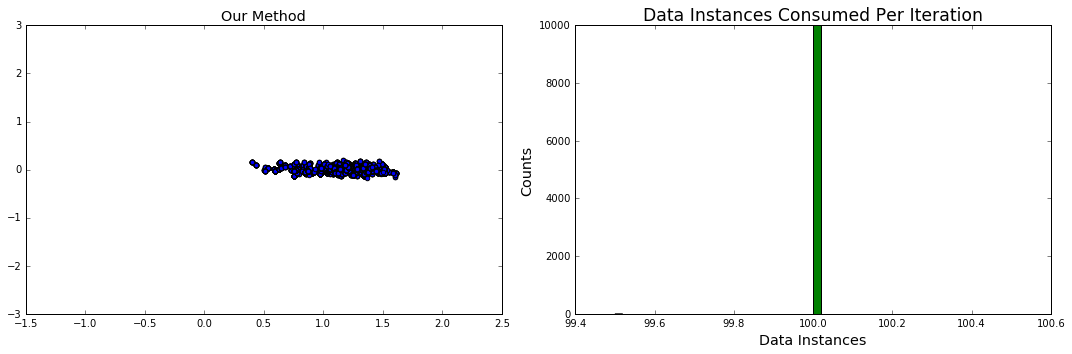

Temperature and minibatch size are:
2 200


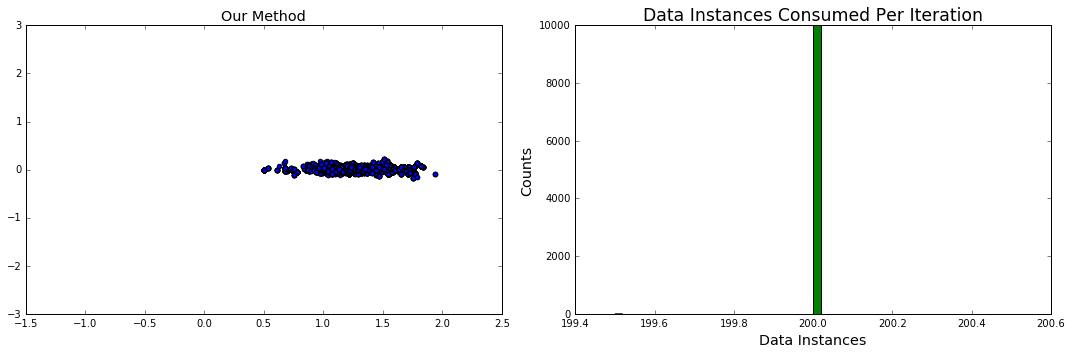

Temperature and minibatch size are:
50 50


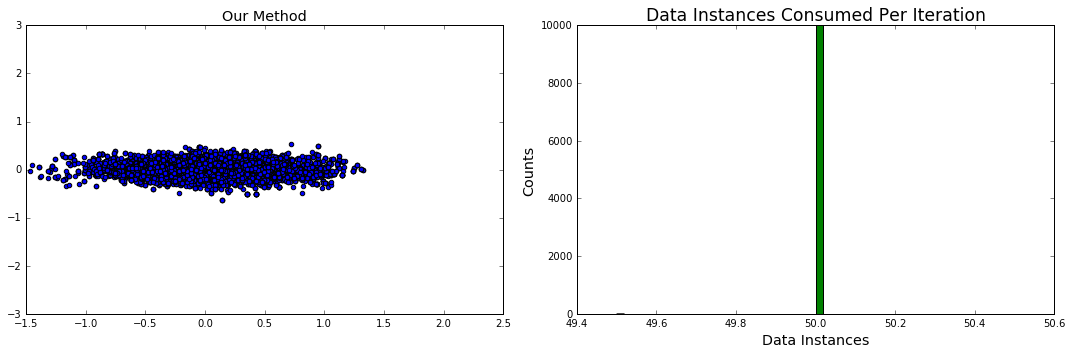

Temperature and minibatch size are:
50 100


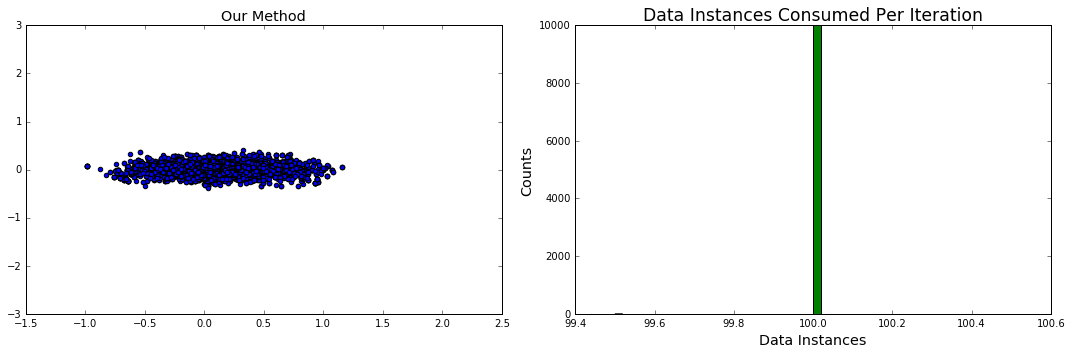

Temperature and minibatch size are:
50 200


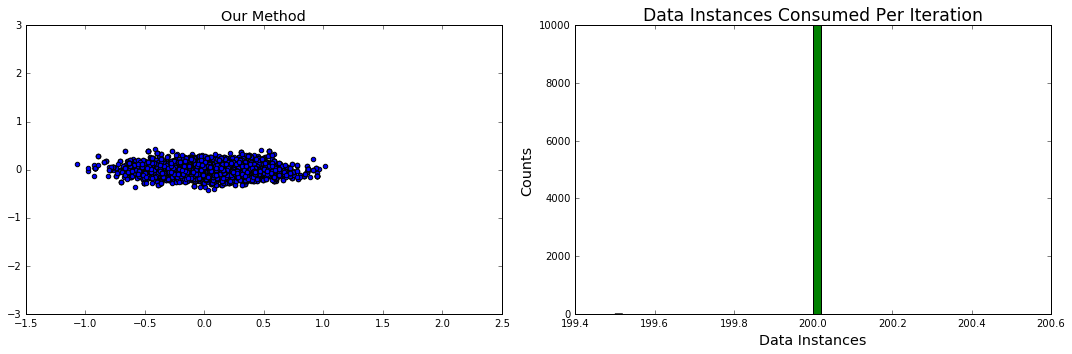

Temperature and minibatch size are:
500 50


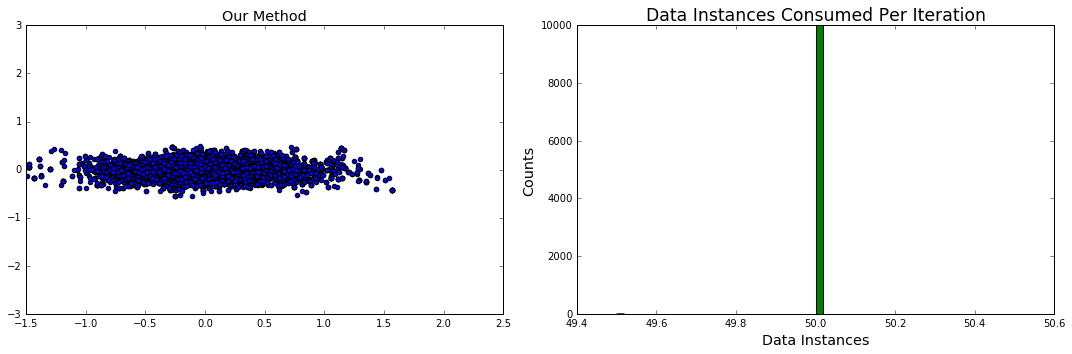

Temperature and minibatch size are:
500 100


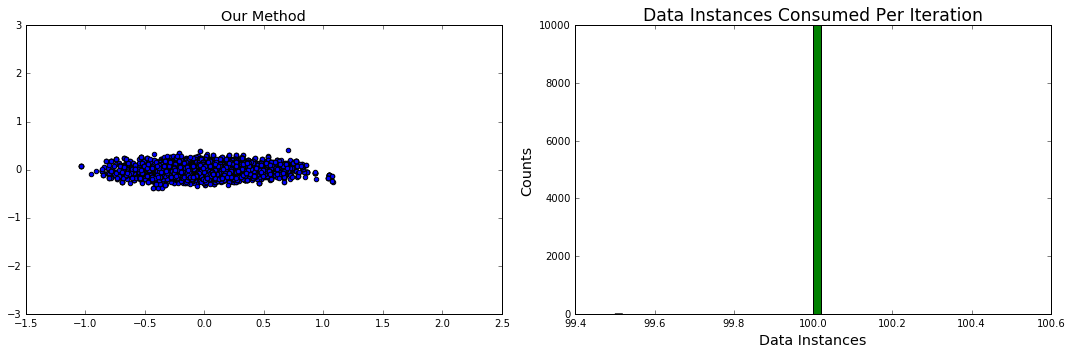

Temperature and minibatch size are:
500 200


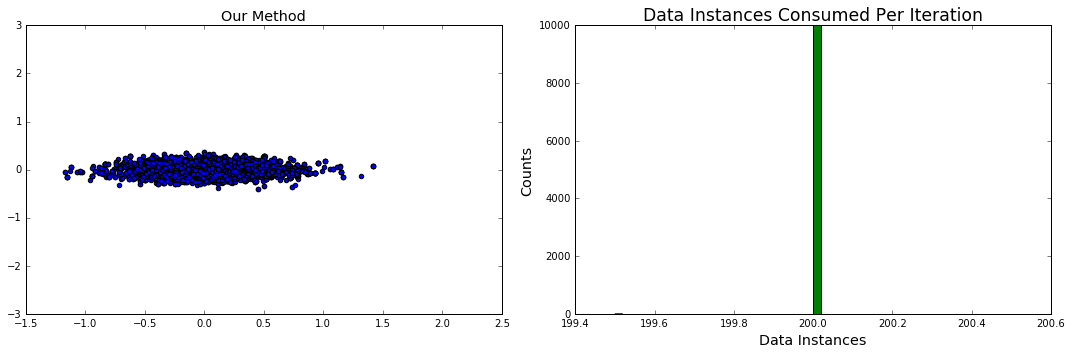

Temperature and minibatch size are:
5000 50


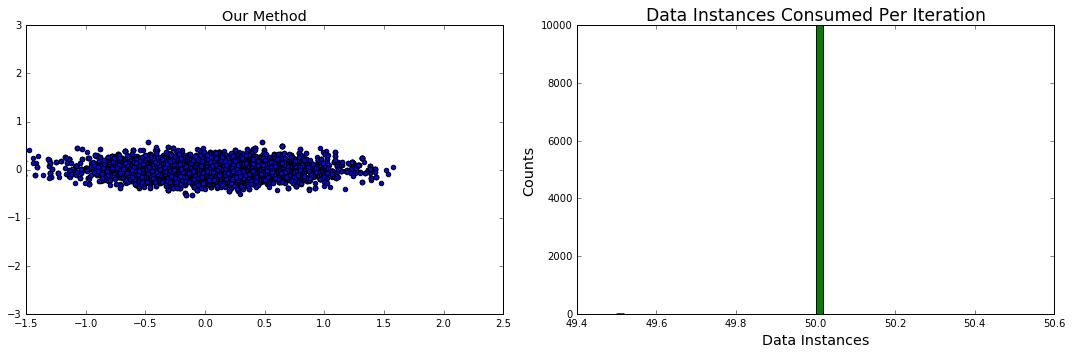

Temperature and minibatch size are:
5000 100


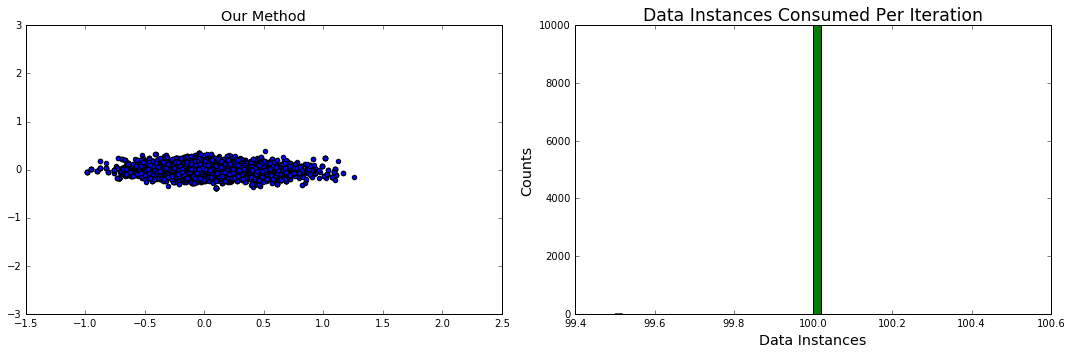

Temperature and minibatch size are:
5000 200


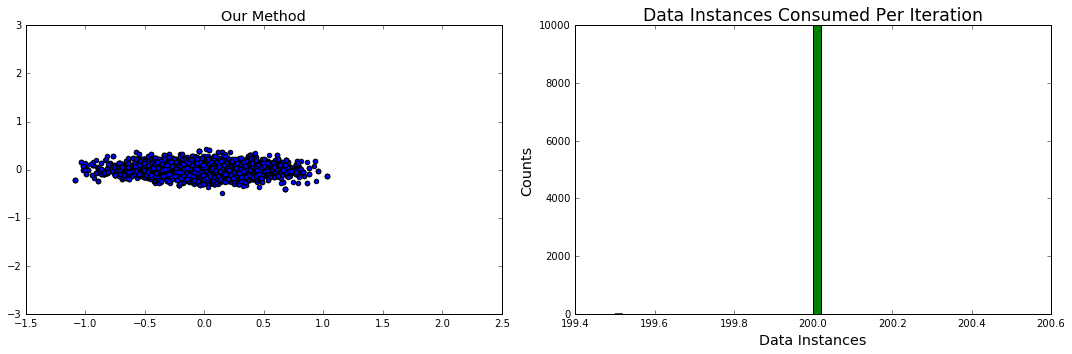

In [36]:
# iterate using different temperature and mb_size
for temperature in [1,2,50,500,5000]:
    for mb_size in [50,100,200]:
        print 'Temperature and minibatch size are:' 
        print temperature, mb_size

        (all3, data_consume) = mhtest.approximate_mh_test(num_passes, \
                             rw_eps, temperature, \
                             mb_size, theta, theta_var, \
                             var_X, mavg)
        # plot result
        fig, axarr = plt.subplots(1,2,figsize=(15,5))
        axarr[0].set_title("Our Method", size="x-large")
        axarr[0].scatter(all3[0], all3[1])
        axarr[0].set_xlim([-1.5,2.5])
        axarr[0].set_ylim([-3,3])
        dataconsume = np.asarray(data_consume)
        axarr[1].set_title("Data Instances Consumed Per Iteration", size="xx-large")
        axarr[1].hist(dataconsume*mb_size, bins=50, facecolor ='green')
        axarr[1].set_xlabel("Data Instances", size="x-large")
        axarr[1].set_ylabel("Counts", size="x-large")
        plt.tight_layout()
        plt.show()